# Lab #4: Working with 'real' data
Haowen Guan

In [2]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py
plt.rcParams["figure.figsize"] = (20,15)

In [9]:
hf = h5py.File('gammaray_lab4.h5', 'r')
hf.keys()
data = np.array(hf.get('data'))
hf.close()
print(data.shape)

(4, 25920001)


## Problem 1
In this problem, we are discovering the data from a gamma-ray satellite orbiting in low Earth orbit. It takes a reading of the number of particles detected every 100 milliseconds, and is in an approximately 90 minute orbit.
<br> **1)** Exploring data

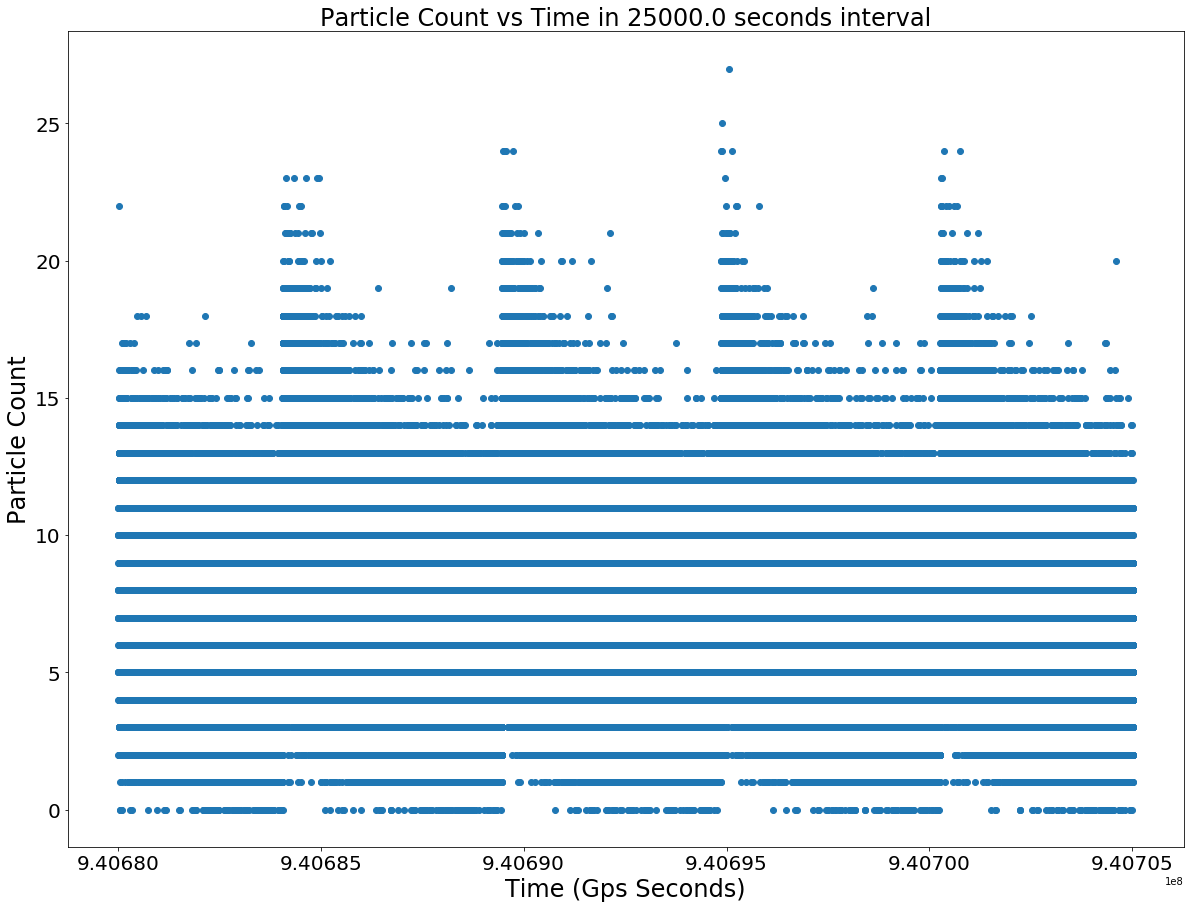

In [78]:
def count_vs_time(start: int, point: int):
    x = data[0, start:start + point]
    y = data[3, start:start + point]
    plt.scatter(x, y)
    plt.title("Particle Count vs Time in " + str(point/10) + " seconds interval", fontsize=24)
    plt.tick_params(labelsize = 20)
    plt.ylabel("Particle Count", fontsize=24)
    plt.xlabel("Time (Gps Seconds)", fontsize=24)
count_vs_time(0, 250000)

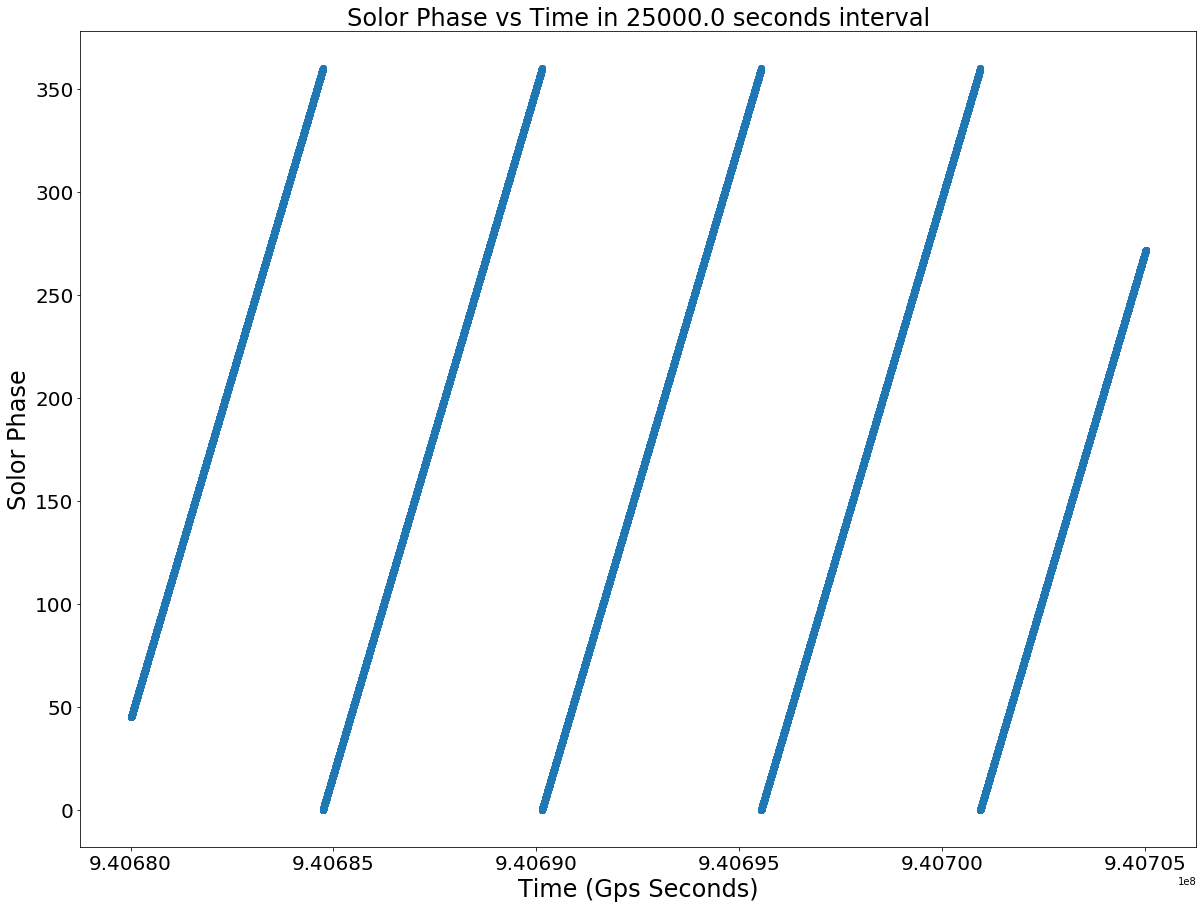

In [10]:
def solar_phase_vs_time(start: int, point: int):
    x = data[0, start:start + point]
    y = data[2, start:start + point]
    plt.scatter(x, y)
    plt.title("Solor Phase vs Time in " + str(point/10) + " seconds interval", fontsize=24)
    plt.tick_params(labelsize = 20)
    plt.ylabel("Solor Phase", fontsize=24)
    plt.xlabel("Time (Gps Seconds)", fontsize=24)
solar_phase_vs_time(0, 250000)

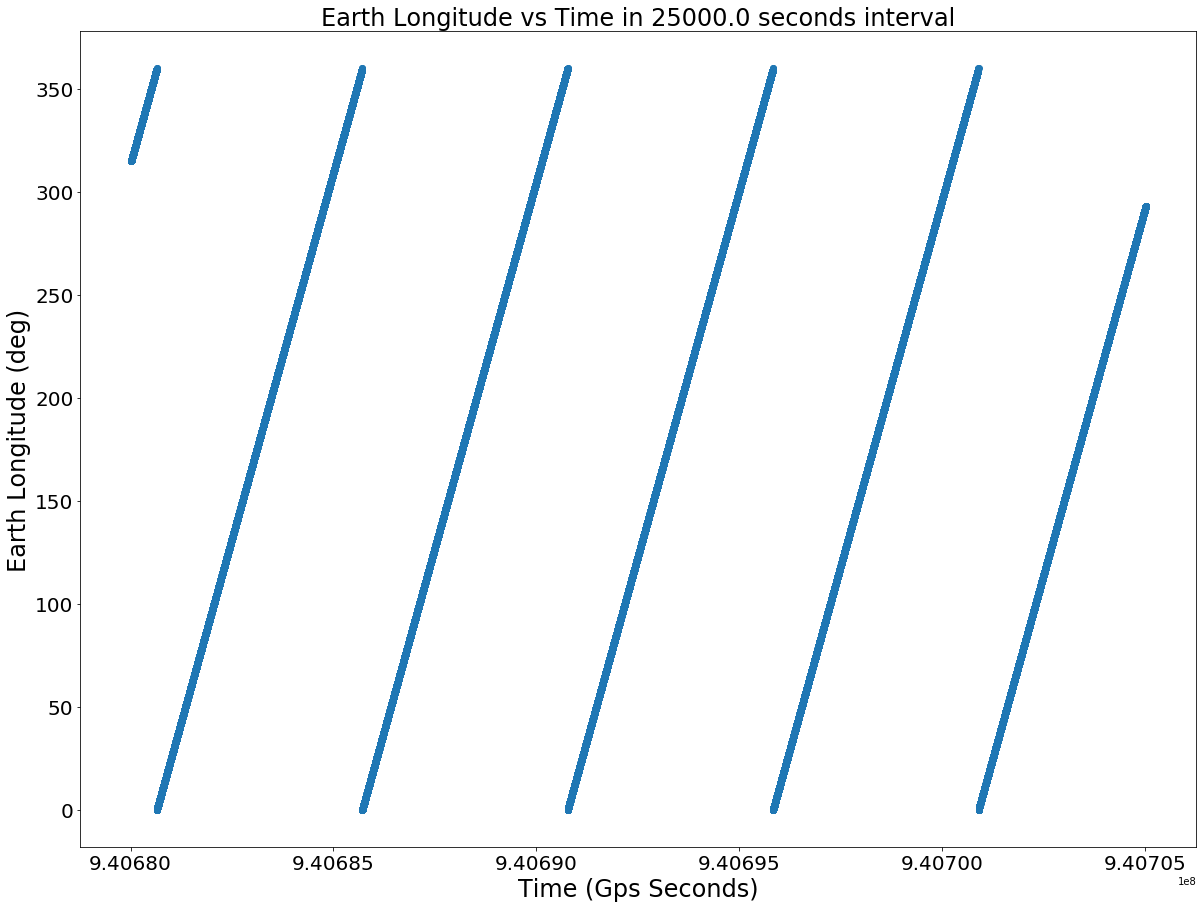

In [76]:
def earth_longitude_vs_time(start: int, point: int):
    x = data[0, start:start + point]
    y = data[1, start:start + point]
    plt.scatter(x, y)
    plt.title("Earth Longitude vs Time in " + str(point/10) + " seconds interval", fontsize=24)
    plt.tick_params(labelsize = 20)
    plt.ylabel("Earth Longitude (deg)", fontsize=24)
    plt.xlabel("Time (Gps Seconds)", fontsize=24)
earth_longitude_vs_time(0, 250000)

**Discovery: Particle counts seems having a periodical pattern correspond to time and the value is discrete. The pattern is that it start with a possitive offset of observing more particle, and gradually decrease. Solar phase and earth longitude also have a similar periodical parttern, that start from 0 deg and go to 360, but they seems having some phase difference.**
<br> **I don't specifically see any signal contamination. For the data I have explored so far, the fringe high and small values are just looks like edge small probability events. For building a background pdf(), I think poisson is a good idea for consider.**

**2)**
As the Particle Count vs Time figure shown above, backgroundcosmic rays seems having a periodical pattern correspond to time. The pattern is that it start with a possitive offset of observing more particle, and gradually decrease.
<br> More specifically, we can see that the initial range of possible value of counts is from **25 to 2**, and till the end of period the range of possible value of counts is from **15 to 0**. As for the period, we already know that the satellite have a approximately 90 minute orbit, also from inspection, we can see that the background distribution follows a approximately **54000** readings period (5400s or 90 minute).

**3)** As the details described above, I found the poisson distribution with **lambda 11.5** fit the initial range really well and the poisson with **lambda 5** fit the end of period range. Shown as follow,

Text(0, 0.5, 'Probability')

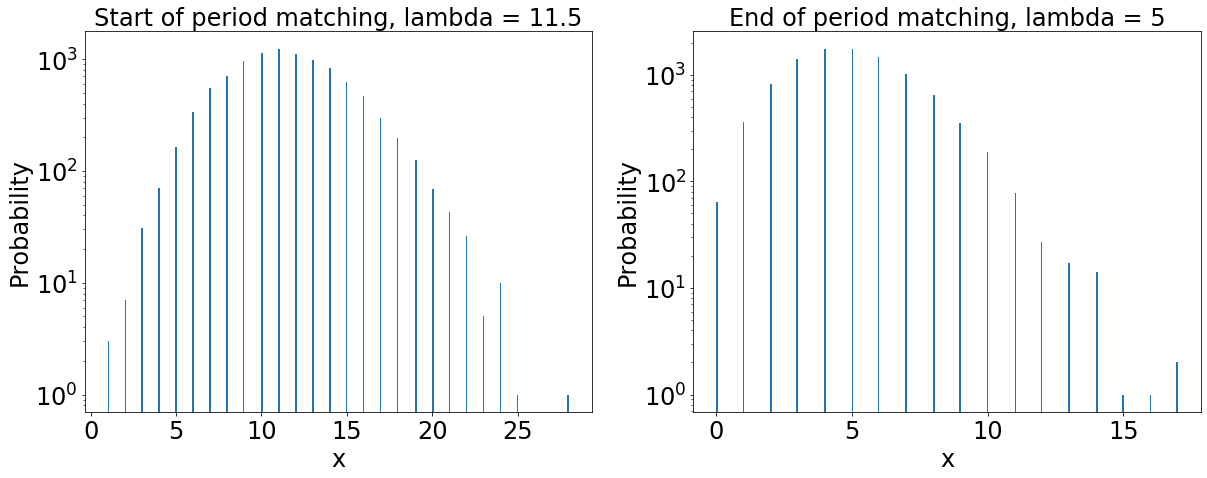

In [71]:
d = stats.poisson.rvs(mu = 11.5, size = 10000)
fig, ax = plt.subplots(1,2)
fig.set_size_inches(20,7)
ax[0].hist(d, 300)
ax[0].set_title("Start of period matching, lambda = 11.5", fontsize=24)
ax[0].set_yscale("log")
ax[0].tick_params(labelsize = 24)
ax[0].set_xlabel("x", fontsize=24)
ax[0].set_ylabel("Probability", fontsize=24)

d = stats.poisson.rvs(mu = 5, size = 10000)
ax[1].hist(d, 300)
ax[1].set_title("End of period matching, lambda = 5", fontsize=24)
ax[1].set_yscale("log")
ax[1].tick_params(labelsize = 24)
ax[1].set_xlabel("x", fontsize=24)
ax[1].set_ylabel("Probability", fontsize=24)

Since the period is 90 minutes or 5400 seconds, and the data is collected in 100 milisecond interval, so there is intotal 5400 points in one period. As I discovered above, the poisson distribtions correspond to the the background varied from 11.5 to 5 during this time interval, it is easy to come up a multiplicative inverse relationship between lambda and time, as
$$ \lambda = \frac {1}{0.0000034259259259*t + 0.1} + 1.5 $$
<br> The background generated by my model is as follow,

Text(0.5, 0, 'Time (Seconds)')

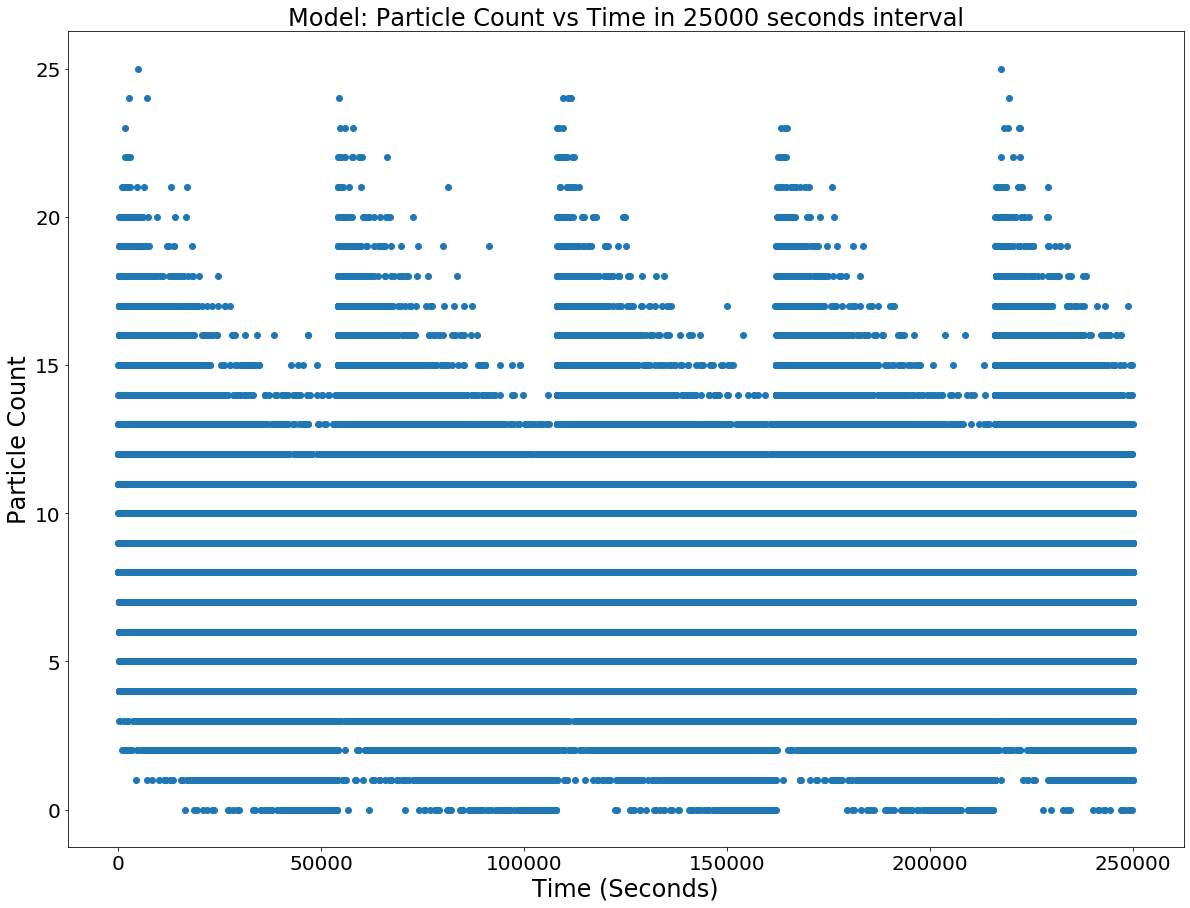

In [95]:
time = np.linspace(0, 250000, 250001)
count = np.array([])
for t in time:
    count = np.append(count, stats.poisson.rvs(mu = 1/(0.0000034259259259*(t % 54000) + 0.1) + 1.5, size = 1))
plt.scatter(time, count)
plt.title("Model: Particle Count vs Time in 25000 seconds interval", fontsize=24)
plt.tick_params(labelsize = 20)
plt.ylabel("Particle Count", fontsize=24)
plt.xlabel("Time (Seconds)", fontsize=24)

My model simulate the background perfectly.
<br> 
<br> **4)** The 5-sigma threshold for a 100 millisecond GRB can be find using the following function, my approach is to use the percentile that corresponds to 5 sigma, and finding the corresponding value of the poisson distribution at the specified time.
<br> For example, I calculate the threshold for time at 0.1 second and 5000 second.

In [75]:
def get_threshold(time: int):
    print(stats.poisson.ppf(stats.norm.cdf(5),mu = 1/(0.0000034259259259*(time % 54000) + 0.1) + 1.5))
get_threshold(1)
get_threshold(50000)

32.0
20.0


## Problem 2 Trasient star
**1)**

In [3]:
hf = h5py.File('images.h5', 'r')
hf.keys()
data2 = np.array(hf.get('imagestack'))
hf.close()
print(data2.shape)

(200, 200, 10)


**2)** 
<br> Exploring the 10 images

Text(0, 0.5, 'Count')

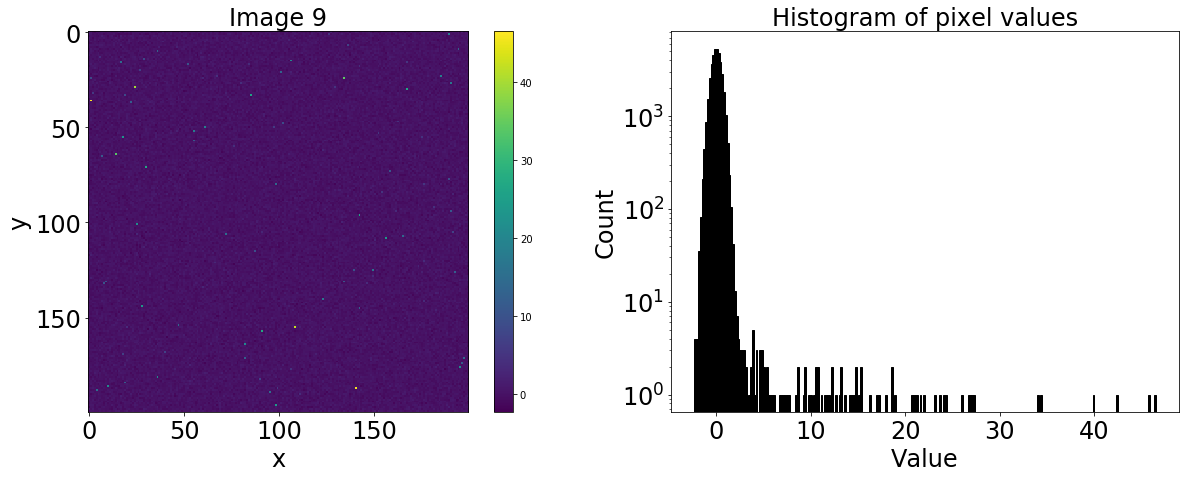

In [33]:
n = 8
image = data2[:,:,n]
fig, ax = plt.subplots(1,2)
fig.set_size_inches(20,7)
obs = ax[0].imshow(image)
fig.colorbar(obs, ax=ax[0])
ax[0].set_title("Image " + str(n + 1), fontsize=24)
ax[0].tick_params(labelsize = 24)
ax[0].set_xlabel("x", fontsize=24)
ax[0].set_ylabel("y", fontsize=24)

ax[1].hist(image.ravel(), bins=256, fc='k', ec='k')
ax[1].set_title("Histogram of pixel values", fontsize=24)
ax[1].set_yscale("log")
ax[1].tick_params(labelsize = 24)
ax[1].set_xlabel("Value", fontsize=24)
ax[1].set_ylabel("Count", fontsize=24)

- By looking at the above exploration, there is for sure star signal contaminations in the telescope background images.

- Below, I am continuing exploring the difference between Images to see if there is any significant difference between images.

Text(0, 0.5, 'Count')

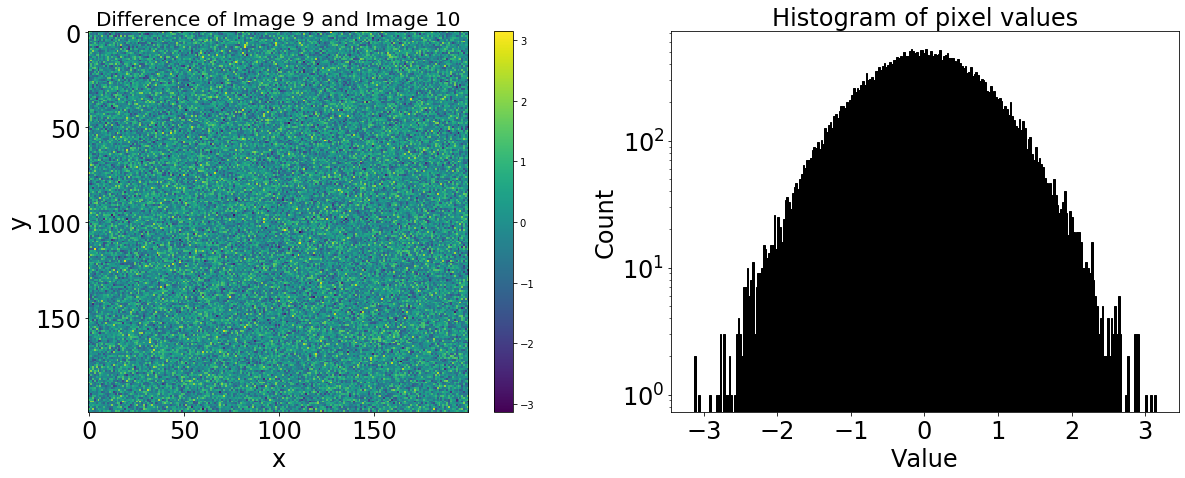

In [65]:
n = 8
image = data2[:,:,n] - data2[:,:,n + 1]
fig, ax = plt.subplots(1,2)
fig.set_size_inches(20,7)
obs = ax[0].imshow(image)
fig.colorbar(obs, ax=ax[0])
ax[0].set_title("Difference of Image " + str(n + 1) + " and Image " + str(n + 2), fontsize=20)
ax[0].tick_params(labelsize = 24)
ax[0].set_xlabel("x", fontsize=24)
ax[0].set_ylabel("y", fontsize=24)

ax[1].hist(image.ravel(), bins=256, fc='k', ec='k')
ax[1].set_title("Histogram of pixel values", fontsize=24)
ax[1].set_yscale("log")
ax[1].tick_params(labelsize = 24)
ax[1].set_xlabel("Value", fontsize=24)
ax[1].set_ylabel("Count", fontsize=24)

- Through explorating multiple combinations, I found that the histogram of pixel values of difference between consecutive images have a perfect gaussian distribution with mean 0. This means that the background is **independent of time (due to perfect gaussian shape)**, and **consistent spatially (due to mean 0)**. 

- Since my goal is to find transient stars, the background pdf() I care is the **background distribution of the difference between two consecutive images**, thus I will try to find a gaussian distribution that fits the shape of histogram of difference image. Though multiple attempts, I found that the **guassian with mean 0 and variance 0.77** fits the background distribution.

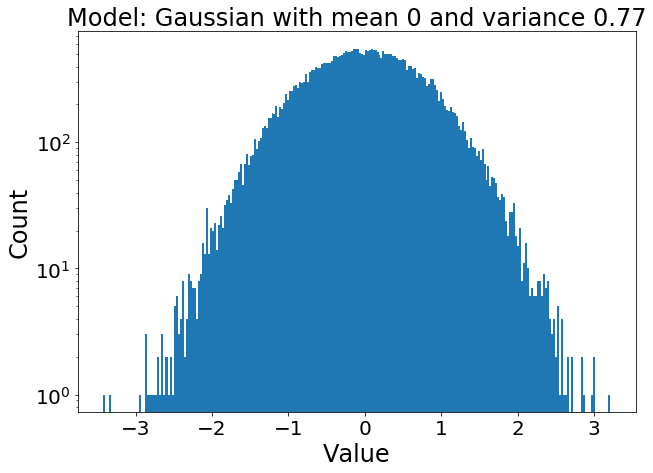

In [70]:
d = stats.norm.rvs(loc = 0, scale = 0.77, size = 40000)
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,7)
ax.hist(d,256)
plt.tick_params(labelsize = 24)
x = np.linspace(-3,3,256)
plt.yscale("log")
plt.title("Model: Gaussian with mean 0 and variance 0.77", fontsize=24)
plt.tick_params(labelsize = 20)
plt.ylabel("Count", fontsize=24)
plt.xlabel("Value", fontsize=24)
plt.show()

**3)**
Since I am looking for a transient star, that only appears in one images, when it occurs, the difference between two consecutive image must be very big, and we use the above guassian background distribtion that represent the difference between two image to identify a occurance of transient star. I will use a threshhold of $ +-5\sigma $ to distinguish a occurance of transient star.

<br> Below is the code that calculate $ +-5\sigma $ threshold value correspond to background distribution and search through the images to check for a occurance of transient.

In [74]:
upperthreshold = stats.norm.ppf(stats.norm.cdf(5),loc = 0, scale = 0.77)
lowerthreshold = stats.norm.ppf(stats.norm.cdf(-5),loc = 0, scale = 0.77)
print("Upper threshold is " + str(upperthreshold) + " and lower threshold is " + str(lowerthreshold))
count = 0
for i in range(9):
    n = 8
    difference = data2[:,:,n] - data2[:,:,n + 1]
    difference = np.reshape(difference, 40000)
    for j in range(40000):
        if (difference[j] >= upperthreshold or difference[j] <= lowerthreshold):
            count += 1
print("Found intotal " + str(count) + " transient star(s)")

Upper threshold is 3.8499999999770353 and lower threshold is -3.850000000000001
Found intotal 0 transient star(s)


Through the code above, I found 0 transient star.

**4)** As the explorations in the 2) part, I discovered two types of information. One is the distribution of telescope images, and the another one is the difference of consecutive images. These are definitly two different distribution.
<br> The approch of finding faintest stars and transient stars is different. Finding faintest star involving compare signal values with other pixels in one image, which should use the distribution of image, and finding transient stars involving compare signal values between two consecutive images, which should use the distribution of difference, thus for the different purpose, we have different pdf().
